# Laduma Analytics Football League Winners Prediction Challenge
# By Mohamed Eltayeb

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams["figure.figsize"] = (12, 8)
pd.set_option('display.max_columns', None)

In [2]:
#Plot the LGBM Features Importances
def plotImp(model, X , num = 40, fig_size = (60, 40)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

In [3]:
#Reduce Memory Usage
def reduce_memory_usage(df):
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    return df

# Read the training and testing data


In [4]:
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")
stats_df = pd.read_csv("game_statistics.csv")

C:\Users\moham\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (19,20,24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
train_df1 = pd.merge(train_df, stats_df, how = 'left', on = 'Game_ID')
test_df1 = pd.merge(test_df, stats_df, how = 'left', on = 'Game_ID')

train_df1 = reduce_memory_usage(train_df1)
test_df1 = reduce_memory_usage(test_df1)

In [6]:
#Drop Columns that Contain Leaks
train_df1.drop(['Goals_scored','Goals_conceded','Action','next_action'],inplace=True,axis=1)
test_df1.drop(['Goals_scored','Goals_conceded','Action','next_action'],inplace=True,axis=1)

# Convert the Tabular Data to Time Series Data

In [7]:
train_df['Date'] = train_df['Date'].astype('datetime64[ns]')
test_df['Date'] = test_df['Date'].astype('datetime64[ns]')
train_df1['Date'] = train_df1['Date'].astype('datetime64[ns]')
test_df1['Date'] = test_df1['Date'].astype('datetime64[ns]')

for dataset in (train_df,test_df,train_df1,test_df1):
    dataset['Month'] = dataset.Date.dt.month        
    dataset['Year'] = dataset.Date.dt.year           
    dataset['WeekOfYear'] = dataset.Date.dt.weekofyear 
    dataset.set_index('Date', inplace=True)

# Exploratory data analysis

# Features:

In [8]:
Var_Def = pd.read_csv('VariableDefinitions.csv')
Var_Def

,Game Statistics,Unnamed: 1
0,Game_ID,Unique ID of the game
1,Player_ID,Unique ID for each player
2,id,Unique ID for each action
3,X,Position ball received at
4,Y,Position ball received at
5,Team,Name of home team
6,Action,"Time of play – positional attack, inaccurate p..."
7,Half,Which half of the game
8,Manager,Manager name (masked)
9,Opposition_Team,Name of opposition team


In [9]:
train_df.shape

(412, 9)

In [10]:
test_df.shape

(234, 8)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 412 entries, 2017-02-15 to 2018-02-09
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Season      412 non-null    int64  
 1   Match_ID    412 non-null    float64
 2   Game_ID     412 non-null    object 
 3   Home Team   412 non-null    object 
 4   Away Team   412 non-null    object 
 5   Score       412 non-null    object 
 6   Month       412 non-null    int64  
 7   Year        412 non-null    int64  
 8   WeekOfYear  412 non-null    int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 32.2+ KB


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 234 entries, 2018-12-08 to 2019-05-14
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Season      234 non-null    int64  
 1   Match_ID    234 non-null    float64
 2   Game_ID     234 non-null    object 
 3   Home Team   234 non-null    object 
 4   Away Team   234 non-null    object 
 5   Month       234 non-null    int64  
 6   Year        234 non-null    int64  
 7   WeekOfYear  234 non-null    int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 16.5+ KB


In [13]:
train_df.head()

,Season,Match_ID,Game_ID,Home Team,Away Team,Score,Month,Year,WeekOfYear
Date,,,,,,,,,
2017-02-15,1,1.000,ID_KAG4KAE9,Antennae,Andromeda,Away win,2,2017,7
2016-09-14,1,12.000,ID_T7H1XN5Z,Andromeda,Antennae,Draw,9,2016,37
2016-12-12,1,13.000,ID_O1P9FGN4,Andromeda,Butterfly,Away win,12,2016,50
2017-01-25,1,14.000,ID_TR5M4KQV,Andromeda,Cigar,Away win,1,2017,4
2016-08-24,1,15.000,ID_EOIECRE2,Andromeda,Circinus,Home Win,8,2016,34


In [14]:
test_df.head()

,Season,Match_ID,Game_ID,Home Team,Away Team,Month,Year,WeekOfYear
Date,,,,,,,,
2018-12-08,3,102.000,ID_8518U587,Antennae,Cosmos Redshift 7,12,2018,49
2018-09-11,3,18.000,ID_H49BIKG7,Cosmos Redshift 7,Tadpole,9,2018,37
2018-09-25,3,32.000,ID_PO6SP4VA,Cosmos Redshift 7,Medusa Merger,9,2018,39
2018-10-02,3,40.000,ID_MZRCNBAQ,Cartwheel,Cosmos Redshift 7,10,2018,40
2018-12-20,3,123.000,ID_CV9VOLIU,Cosmos Redshift 7,Needle,12,2018,51


# Plots


<AxesSubplot:>

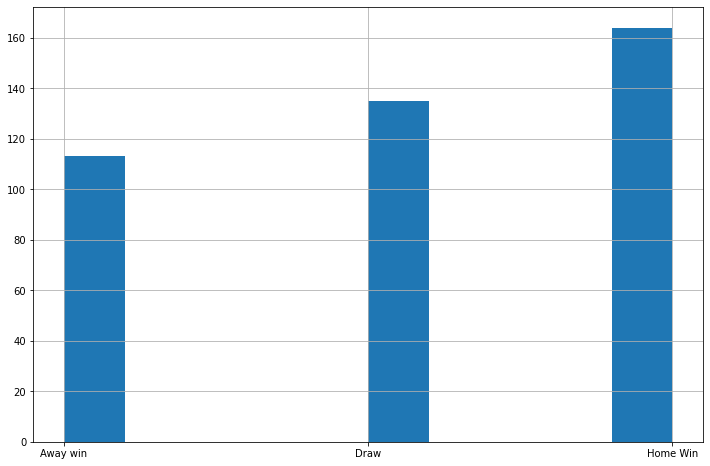

In [15]:
#Target Histogram
train_df['Score'].hist()

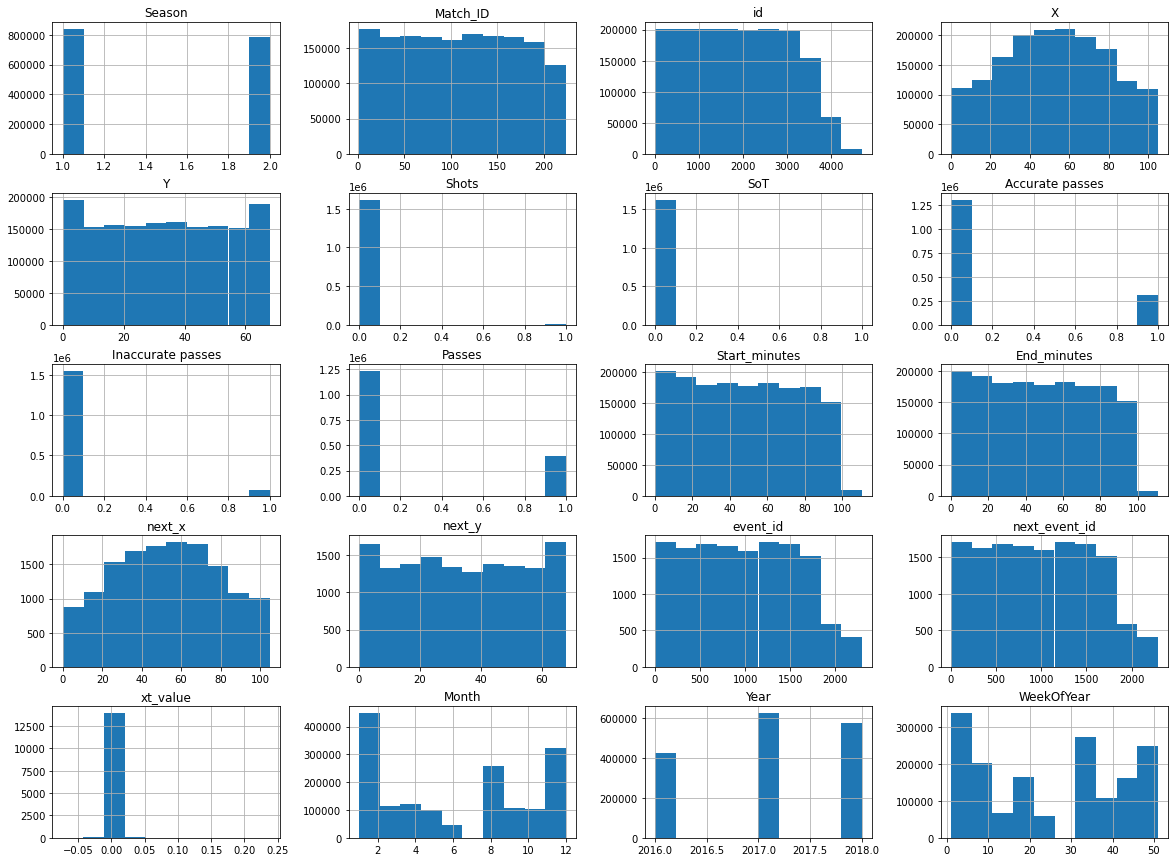

In [16]:
#Numerical Features Histograms (Train)
num_feats = list(train_df1.select_dtypes(include=['int64', 'float64', 'int32','float16','int8']).columns)
train_df1[num_feats].hist(figsize=(20,15));

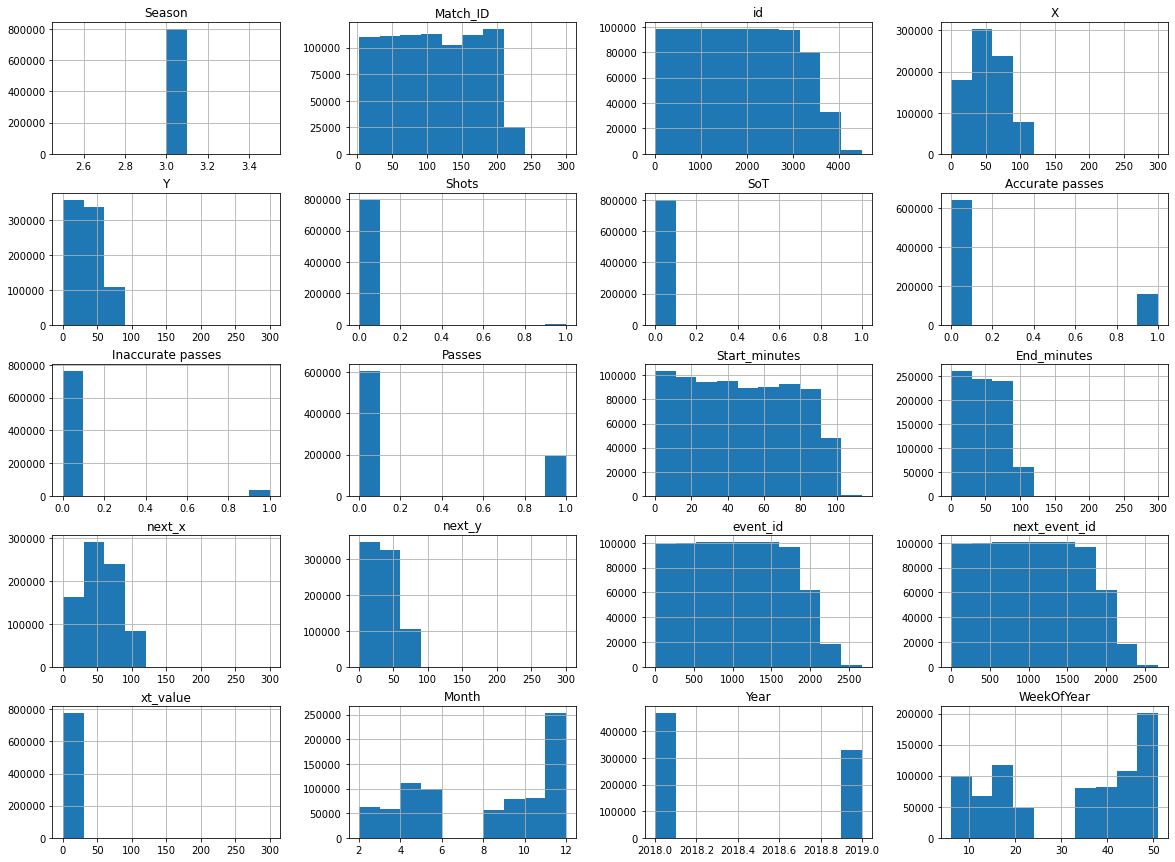

In [17]:
#Numerical Features Histograms (Test)
num_feats = list(test_df1.select_dtypes(include=['int64', 'float64', 'int32','float16','int8']).columns)
test_df1[num_feats].hist(figsize=(20,15));

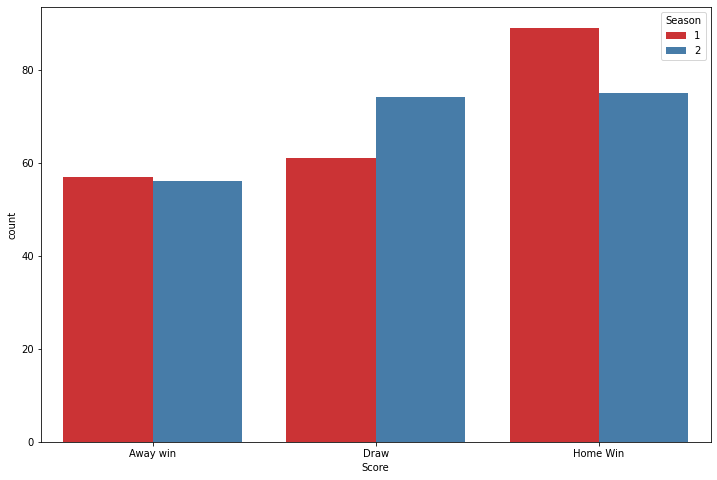

In [18]:
#Score_Season 
sns.countplot( x='Score', data=train_df, hue="Season", palette="Set1");

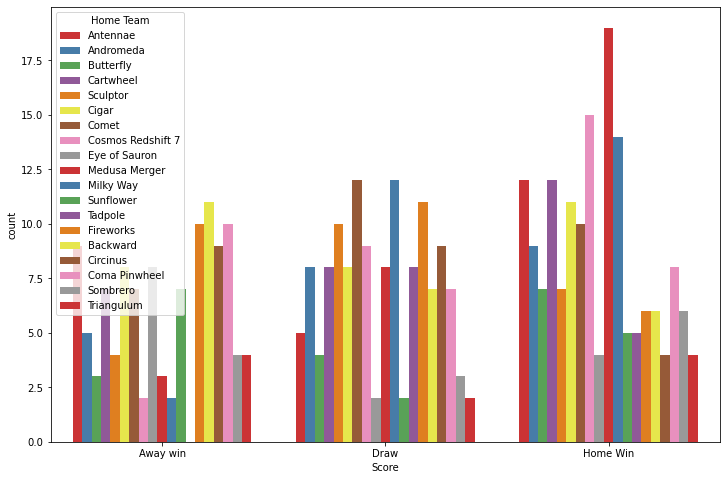

In [19]:
#Score_HomeTeam
sns.countplot( x='Score', data=train_df, hue="Home Team", palette="Set1");

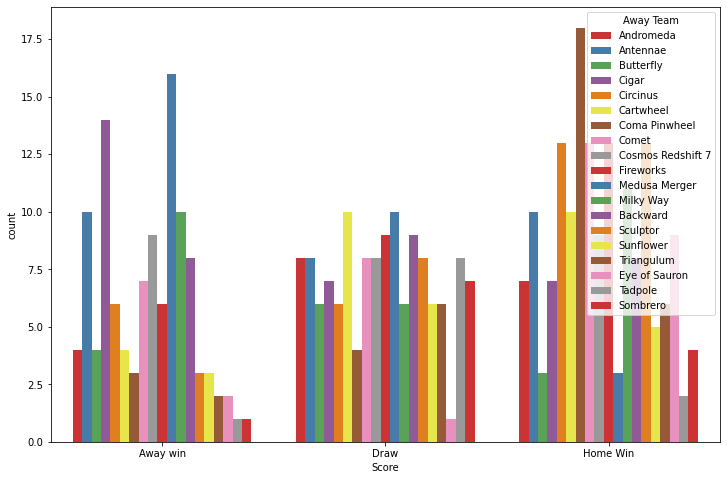

In [20]:
#Score_Away
sns.countplot( x='Score', data=train_df, hue="Away Team", palette="Set1");

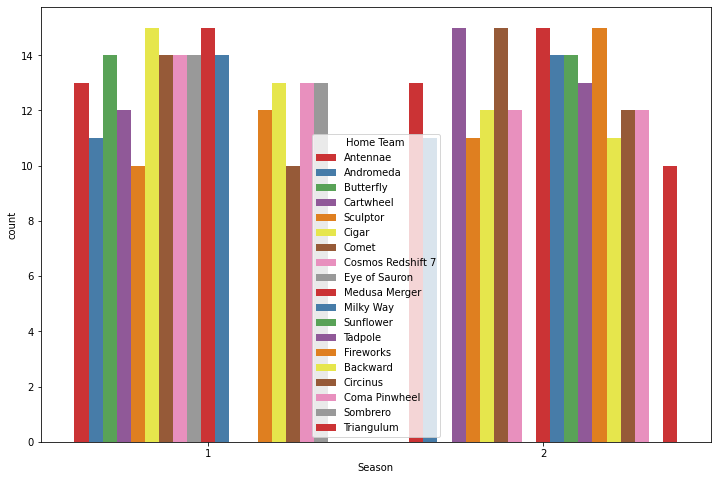

In [21]:
#Season_HomeTeam (Train)
sns.countplot( x='Season', data=train_df, hue="Home Team", palette="Set1");

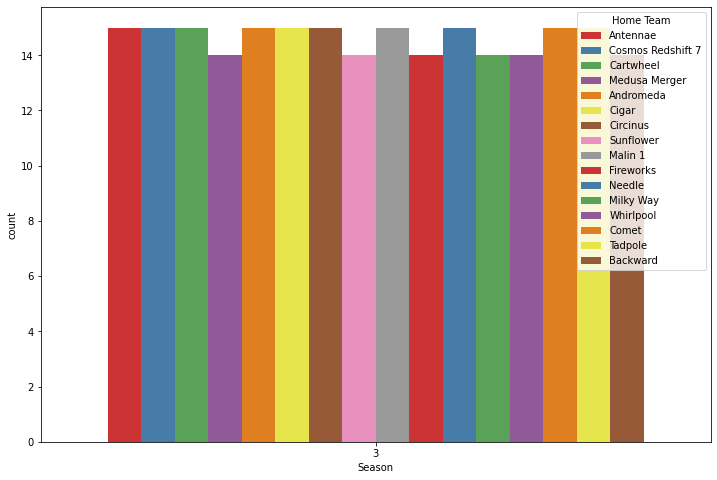

In [22]:
#Season_HomeTeam (Test)
sns.countplot( x='Season', data=test_df, hue="Home Team", palette="Set1");

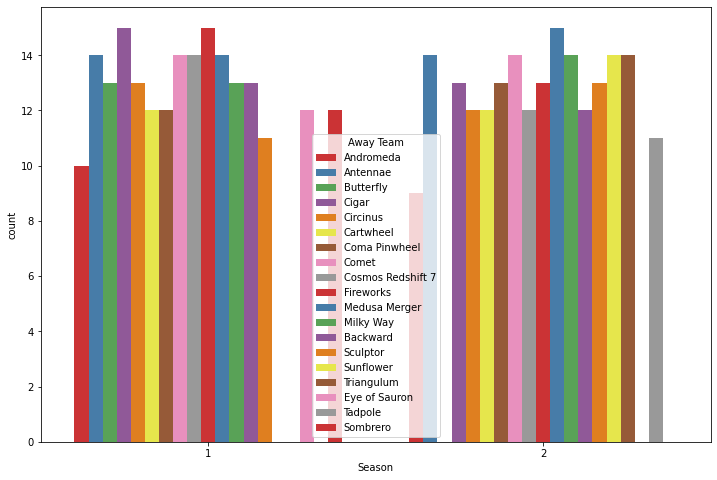

In [23]:
#Season_AwayTeam (Train)
sns.countplot( x='Season', data=train_df, hue="Away Team", palette="Set1");

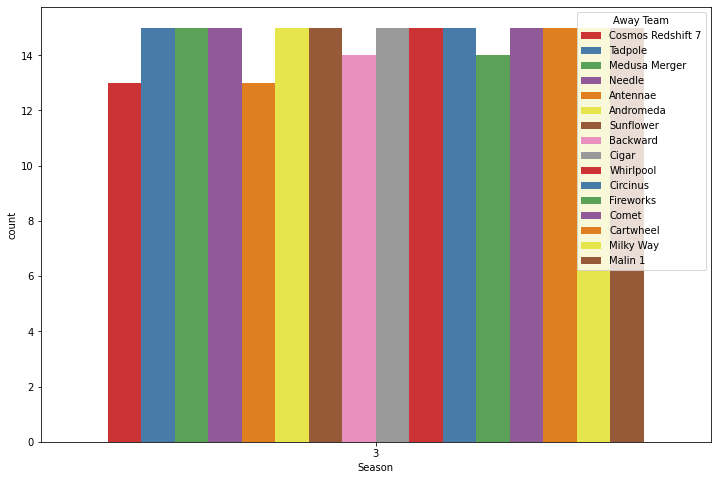

In [24]:
#Season_AwayTeam (Test)
sns.countplot( x='Season', data=test_df, hue="Away Team", palette="Set1");

# Feature Engineering

## Adding Grouped Aggregations Features

In [25]:
for dataset in (train_df1,test_df1):
    dataset['Game_ID_Half'] = dataset['Game_ID'].astype(str) + '_' + dataset['Half'].astype(str)

In [26]:
df = pd.concat([train_df1, test_df1])
ShotsHomeTeam = dict(df[df['Home Team'] == df['Team']].groupby('Game_ID')['Shots'].sum())
SoTHomeTeam = dict(df[df['Home Team'] == df['Team']].groupby('Game_ID')['SoT'].sum())
PassesHomeTeam = df[df['Home Team'] == df['Team']].groupby('Game_ID')['Passes'].sum()
AccurHomeTeam = df[df['Home Team'] == df['Team']].groupby('Game_ID')['Accurate passes'].sum()
InaccurHomeTeam = dict(df[df['Home Team'] == df['Team']].groupby('Game_ID')['Inaccurate passes'].sum())

ShotsAwayTeam = dict(df[df['Away Team'] == df['Team']].groupby('Game_ID')['Shots'].sum())
SoTAwayTeam = dict(df[df['Away Team'] == df['Team']].groupby('Game_ID')['SoT'].sum())
PassesAwayTeam = df[df['Away Team'] == df['Team']].groupby('Game_ID')['Passes'].sum()
AccurAwayTeam = df[df['Away Team'] == df['Team']].groupby('Game_ID')['Accurate passes'].sum()
InaccurAwayTeam = dict(df[df['Away Team'] == df['Team']].groupby('Game_ID')['Inaccurate passes'].sum())

ShotsMatch = dict(df.groupby(['Game_ID'])['Shots'].sum())
SoTMatch = dict(df.groupby(['Game_ID'])['SoT'].sum())
PassesMatch = df.groupby(['Game_ID'])['Passes'].sum()
AccurMatch = df.groupby(['Game_ID'])['Accurate passes'].sum()
InaccurMatch = dict(df.groupby(['Game_ID'])['Inaccurate passes'].sum())

ShotsHalfHome = dict(df[df['Home Team'] == df['Team']].groupby(['Game_ID_Half'])['Shots'].sum())
SoTHalfHome = dict(df[df['Home Team'] == df['Team']].groupby(['Game_ID_Half'])['SoT'].sum())
PassesHalfHome = df[df['Home Team'] == df['Team']].groupby(['Game_ID_Half'])['Passes'].sum()
AccurHalfHome = df[df['Home Team'] == df['Team']].groupby(['Game_ID_Half'])['Accurate passes'].sum()
InaccurHalfHome = dict(df[df['Home Team'] == df['Team']].groupby(['Game_ID_Half'])['Inaccurate passes'].sum())

ShotsHalfAway = dict(df[df['Away Team'] == df['Team']].groupby(['Game_ID_Half'])['Shots'].sum())
SoTHalfAway = dict(df[df['Away Team'] == df['Team']].groupby(['Game_ID_Half'])['SoT'].sum())
PassesHalfAway = df[df['Away Team'] == df['Team']].groupby(['Game_ID_Half'])['Passes'].sum()
AccurHalfAway = df[df['Away Team'] == df['Team']].groupby(['Game_ID_Half'])['Accurate passes'].sum()
InaccurHalfAway = dict(df[df['Away Team'] == df['Team']].groupby(['Game_ID_Half'])['Inaccurate passes'].sum())

In [27]:
TotalPassesHomeTeam_dict = dict(PassesHomeTeam)
TotalAccurHomeTeam_dict = dict(AccurHomeTeam)
TotalPassesAwayTeam_dict = dict(PassesAwayTeam)
TotalAccurAwayTeam_dict = dict(AccurAwayTeam)
TotalPassesMatch_dict = dict(PassesMatch)
TotalAccurMatch_dict = dict(AccurMatch)
TotalPassesHalfHome_dict = dict(PassesHalfHome)
TotalAccurHalfHome_dict = dict(AccurHalfHome)
TotalPassesHalfAway_dict = dict(PassesHalfAway)
TotalAccurHalfAway_dict = dict(AccurHalfAway)

AccurPassesHome = dict(AccurHomeTeam / PassesHomeTeam)
AccurPassesAway = dict(AccurAwayTeam / PassesAwayTeam)
AccurPassesMatch = dict(AccurMatch / PassesMatch)
AccurPassesHalfHome = dict(AccurHalfHome / PassesHalfHome)
AccurPassesHalfAway = dict(AccurHalfAway / PassesHalfAway)

In [28]:
for dataset in (train_df,test_df):
    dataset['TotalShotsPerHomeTeam'] = dataset['Game_ID'].map(ShotsHomeTeam)
    dataset['TotalSoTPerHomeTeam'] = dataset['Game_ID'].map(SoTHomeTeam)
    dataset['TotalPassesPerHomeTeam'] = dataset['Game_ID'].map(TotalPassesHomeTeam_dict)
    dataset['TotalAccurPerHomeTeam'] = dataset['Game_ID'].map(TotalAccurHomeTeam_dict)
    dataset['TotalInaccurPerHomeTeam'] = dataset['Game_ID'].map(InaccurHomeTeam)

    dataset['TotalShotsPerAwayTeam'] = dataset['Game_ID'].map(ShotsAwayTeam)
    dataset['TotalSoTPerAwayTeam'] = dataset['Game_ID'].map(SoTAwayTeam)
    dataset['TotalPassesPerAwayTeam'] = dataset['Game_ID'].map(TotalPassesAwayTeam_dict)
    dataset['TotalAccurPerAwayTeam'] = dataset['Game_ID'].map(TotalAccurAwayTeam_dict)
    dataset['TotalInaccurPerAwayTeam'] = dataset['Game_ID'].map(InaccurAwayTeam)
    
    dataset['ShotsHomeAway_diff'] = dataset['TotalShotsPerHomeTeam'] - dataset['TotalShotsPerAwayTeam']
    dataset['SoTHomeAway_diff'] = dataset['TotalSoTPerHomeTeam'] - dataset['TotalSoTPerAwayTeam']    
    
    dataset['TotalShotsPerMatch'] = dataset['Game_ID'].map(ShotsMatch)
    dataset['TotalSoTPerMatch'] = dataset['Game_ID'].map(SoTMatch)
    dataset['TotalPassesPerMatch'] = dataset['Game_ID'].map(TotalPassesMatch_dict)
    dataset['TotalAccurPerMatch'] = dataset['Game_ID'].map(TotalAccurMatch_dict)
    dataset['TotalInaccurPerMatch'] = dataset['Game_ID'].map(InaccurMatch)
    
    dataset['AccurPassesHome'] = dataset['Game_ID'].map(AccurPassesHome)
    dataset['AccurPassesAway'] = dataset['Game_ID'].map(AccurPassesAway)
    dataset['AccurPassesMatch'] = dataset['Game_ID'].map(AccurPassesMatch)


df['TotalShotsPerHalfHome'] = df['Game_ID_Half'].map(ShotsHalfHome)
df['TotalSoTPerHalfHome'] = df['Game_ID_Half'].map(SoTHalfHome)
df['TotalPassesPerHalfHome'] = df['Game_ID_Half'].map(TotalPassesHalfHome_dict)
df['TotalAccurPerHalfHome'] = df['Game_ID_Half'].map(TotalAccurHalfHome_dict)
df['TotalInaccurPerHalfHome'] = df['Game_ID_Half'].map(InaccurHalfHome)
df['AccurPassesHalfHome'] = df['Game_ID_Half'].map(AccurPassesHalfHome)

df['TotalShotsPerHalfAway'] = df['Game_ID_Half'].map(ShotsHalfAway)
df['TotalSoTPerHalfAway'] = df['Game_ID_Half'].map(SoTHalfAway)
df['TotalPassesPerHalfAway'] = df['Game_ID_Half'].map(TotalPassesHalfAway_dict)
df['TotalAccurPerHalfAway'] = df['Game_ID_Half'].map(TotalAccurHalfAway_dict)
df['TotalInaccurPerHalfAway'] = df['Game_ID_Half'].map(InaccurHalfAway)
df['AccurPassesHalfAway'] = df['Game_ID_Half'].map(AccurPassesHalfAway)

for dataset in (train_df,test_df):
    for team in ('Home','Away'):
        dataset['ShotsPerHalf1'+team] = dataset['Game_ID'].map(dict((df[df['Half'] == '1st half']).groupby('Game_ID')['TotalShotsPerHalf'+team].last())).astype(float)
        dataset['ShotsPerHalf2'+team] = dataset['Game_ID'].map(dict((df[df['Half'] == '2nd half']).groupby('Game_ID')['TotalShotsPerHalf'+team].last())).astype(float)

        dataset['SoTPerHalf1'+team] = dataset['Game_ID'].map(dict((df[df['Half'] == '1st half']).groupby('Game_ID')['TotalSoTPerHalf'+team].last())).astype(float)
        dataset['SoTPerHalf2'+team] = dataset['Game_ID'].map(dict((df[df['Half'] == '2nd half']).groupby('Game_ID')['TotalSoTPerHalf'+team].last())).astype(float)

        dataset['PassesPerHalf1'+team] = dataset['Game_ID'].map(dict((df[df['Half'] == '1st half']).groupby('Game_ID')['TotalPassesPerHalf'+team].last())).astype(float)
        dataset['PassesPerHalf2'+team] = dataset['Game_ID'].map(dict((df[df['Half'] == '2nd half']).groupby('Game_ID')['TotalPassesPerHalf'+team].last())).astype(float)

        dataset['AccurPerHalf1'+team] = dataset['Game_ID'].map(dict((df[df['Half'] == '1st half']).groupby('Game_ID')['TotalAccurPerHalf'+team].last())).astype(float)
        dataset['AccurPerHalf2'+team] = dataset['Game_ID'].map(dict((df[df['Half'] == '2nd half']).groupby('Game_ID')['TotalAccurPerHalf'+team].last())).astype(float)

        dataset['InaccurPerHalf1'+team] = dataset['Game_ID'].map(dict((df[df['Half'] == '1st half']).groupby('Game_ID')['TotalInaccurPerHalf'+team].last())).astype(float)
        dataset['InaccurPerHalf2'+team] = dataset['Game_ID'].map(dict((df[df['Half'] == '2nd half']).groupby('Game_ID')['TotalInaccurPerHalf'+team].last())).astype(float)

        dataset['AccurPassesPerHalf1'+team] = (dataset['Game_ID'].map(dict((df[df['Half'] == '1st half']).groupby('Game_ID')['AccurPassesHalf'+team].last())))
        dataset['AccurPassesPerHalf2'+team] = (dataset['Game_ID'].map(dict((df[df['Half'] == '2nd half']).groupby('Game_ID')['AccurPassesHalf'+team].last())))

    dataset['ShotsHalf1_diff'] = (dataset['ShotsPerHalf1Home'] - dataset['ShotsPerHalf1Away']).astype(float)
    dataset['ShotsHalf2_diff'] = (dataset['ShotsPerHalf2Home'] - dataset['ShotsPerHalf2Away']).astype(float)
    dataset['SoTHalf1_diff'] = (dataset['SoTPerHalf1Home'] - dataset['SoTPerHalf1Away']).astype(float)
    dataset['SoTHalf2_diff'] = (dataset['SoTPerHalf2Home'] - dataset['SoTPerHalf2Away']).astype(float)


## Label Encoding for The Teams Names

In [29]:
le = LabelEncoder()
full_data = pd.concat([train_df, test_df],axis=0)

full_data["Home Team"] = le.fit_transform(full_data["Home Team"])
mapping = dict(zip(le.classes_, range(len((le.classes_)))))

train_df["Home Team"] = train_df["Home Team"].apply(lambda x: mapping[x])
train_df["Away Team"] = train_df["Away Team"].apply(lambda x: mapping[x])

test_df["Home Team"] = test_df["Home Team"].apply(lambda x: mapping[x])
test_df["Away Team"] = test_df["Away Team"].apply(lambda x: mapping[x])

train_df[['Away Team','Home Team']] = train_df[['Away Team','Home Team']].astype(int)
test_df[['Away Team','Home Team']] = test_df[['Away Team','Home Team']].astype(int)

## Have The Two Teams Met Each Other Before? 

In [30]:
train_df['MetBefore'] = (train_df['Home Team'] + train_df['Away Team'])
test_df['MetBefore'] = (test_df['Home Team'] + test_df['Away Team'])

## Drop 'Game_ID' and 'Match_ID'

In [31]:
ID = test_df['Game_ID']
test_df.drop(['Game_ID','Match_ID'],inplace=True,axis=1)
train_df.drop(['Game_ID','Match_ID'],inplace=True,axis=1)

# Label Encoding The Target

In [32]:
train_df['Score'] = train_df.Score.map({'Away win': -1,'Draw': 0,'Home Win': 1})
train_df['Score'] = (train_df['Score']).astype(int)

## Validation

In [33]:
lgbm = LGBMClassifier(random_state=42)

In [34]:
Fold_train = train_df[train_df.Season == 1]
Fold_test = train_df[train_df.Season == 2]

print('Validation...')
lgbm.fit(Fold_train.drop('Score',axis=1),Fold_train['Score'])
y_pred = lgbm.predict(Fold_test.drop('Score',axis=1))
accuracy_score(y_pred,Fold_test['Score'])

Validation...


0.43902439024390244

## Show the Features Importances 

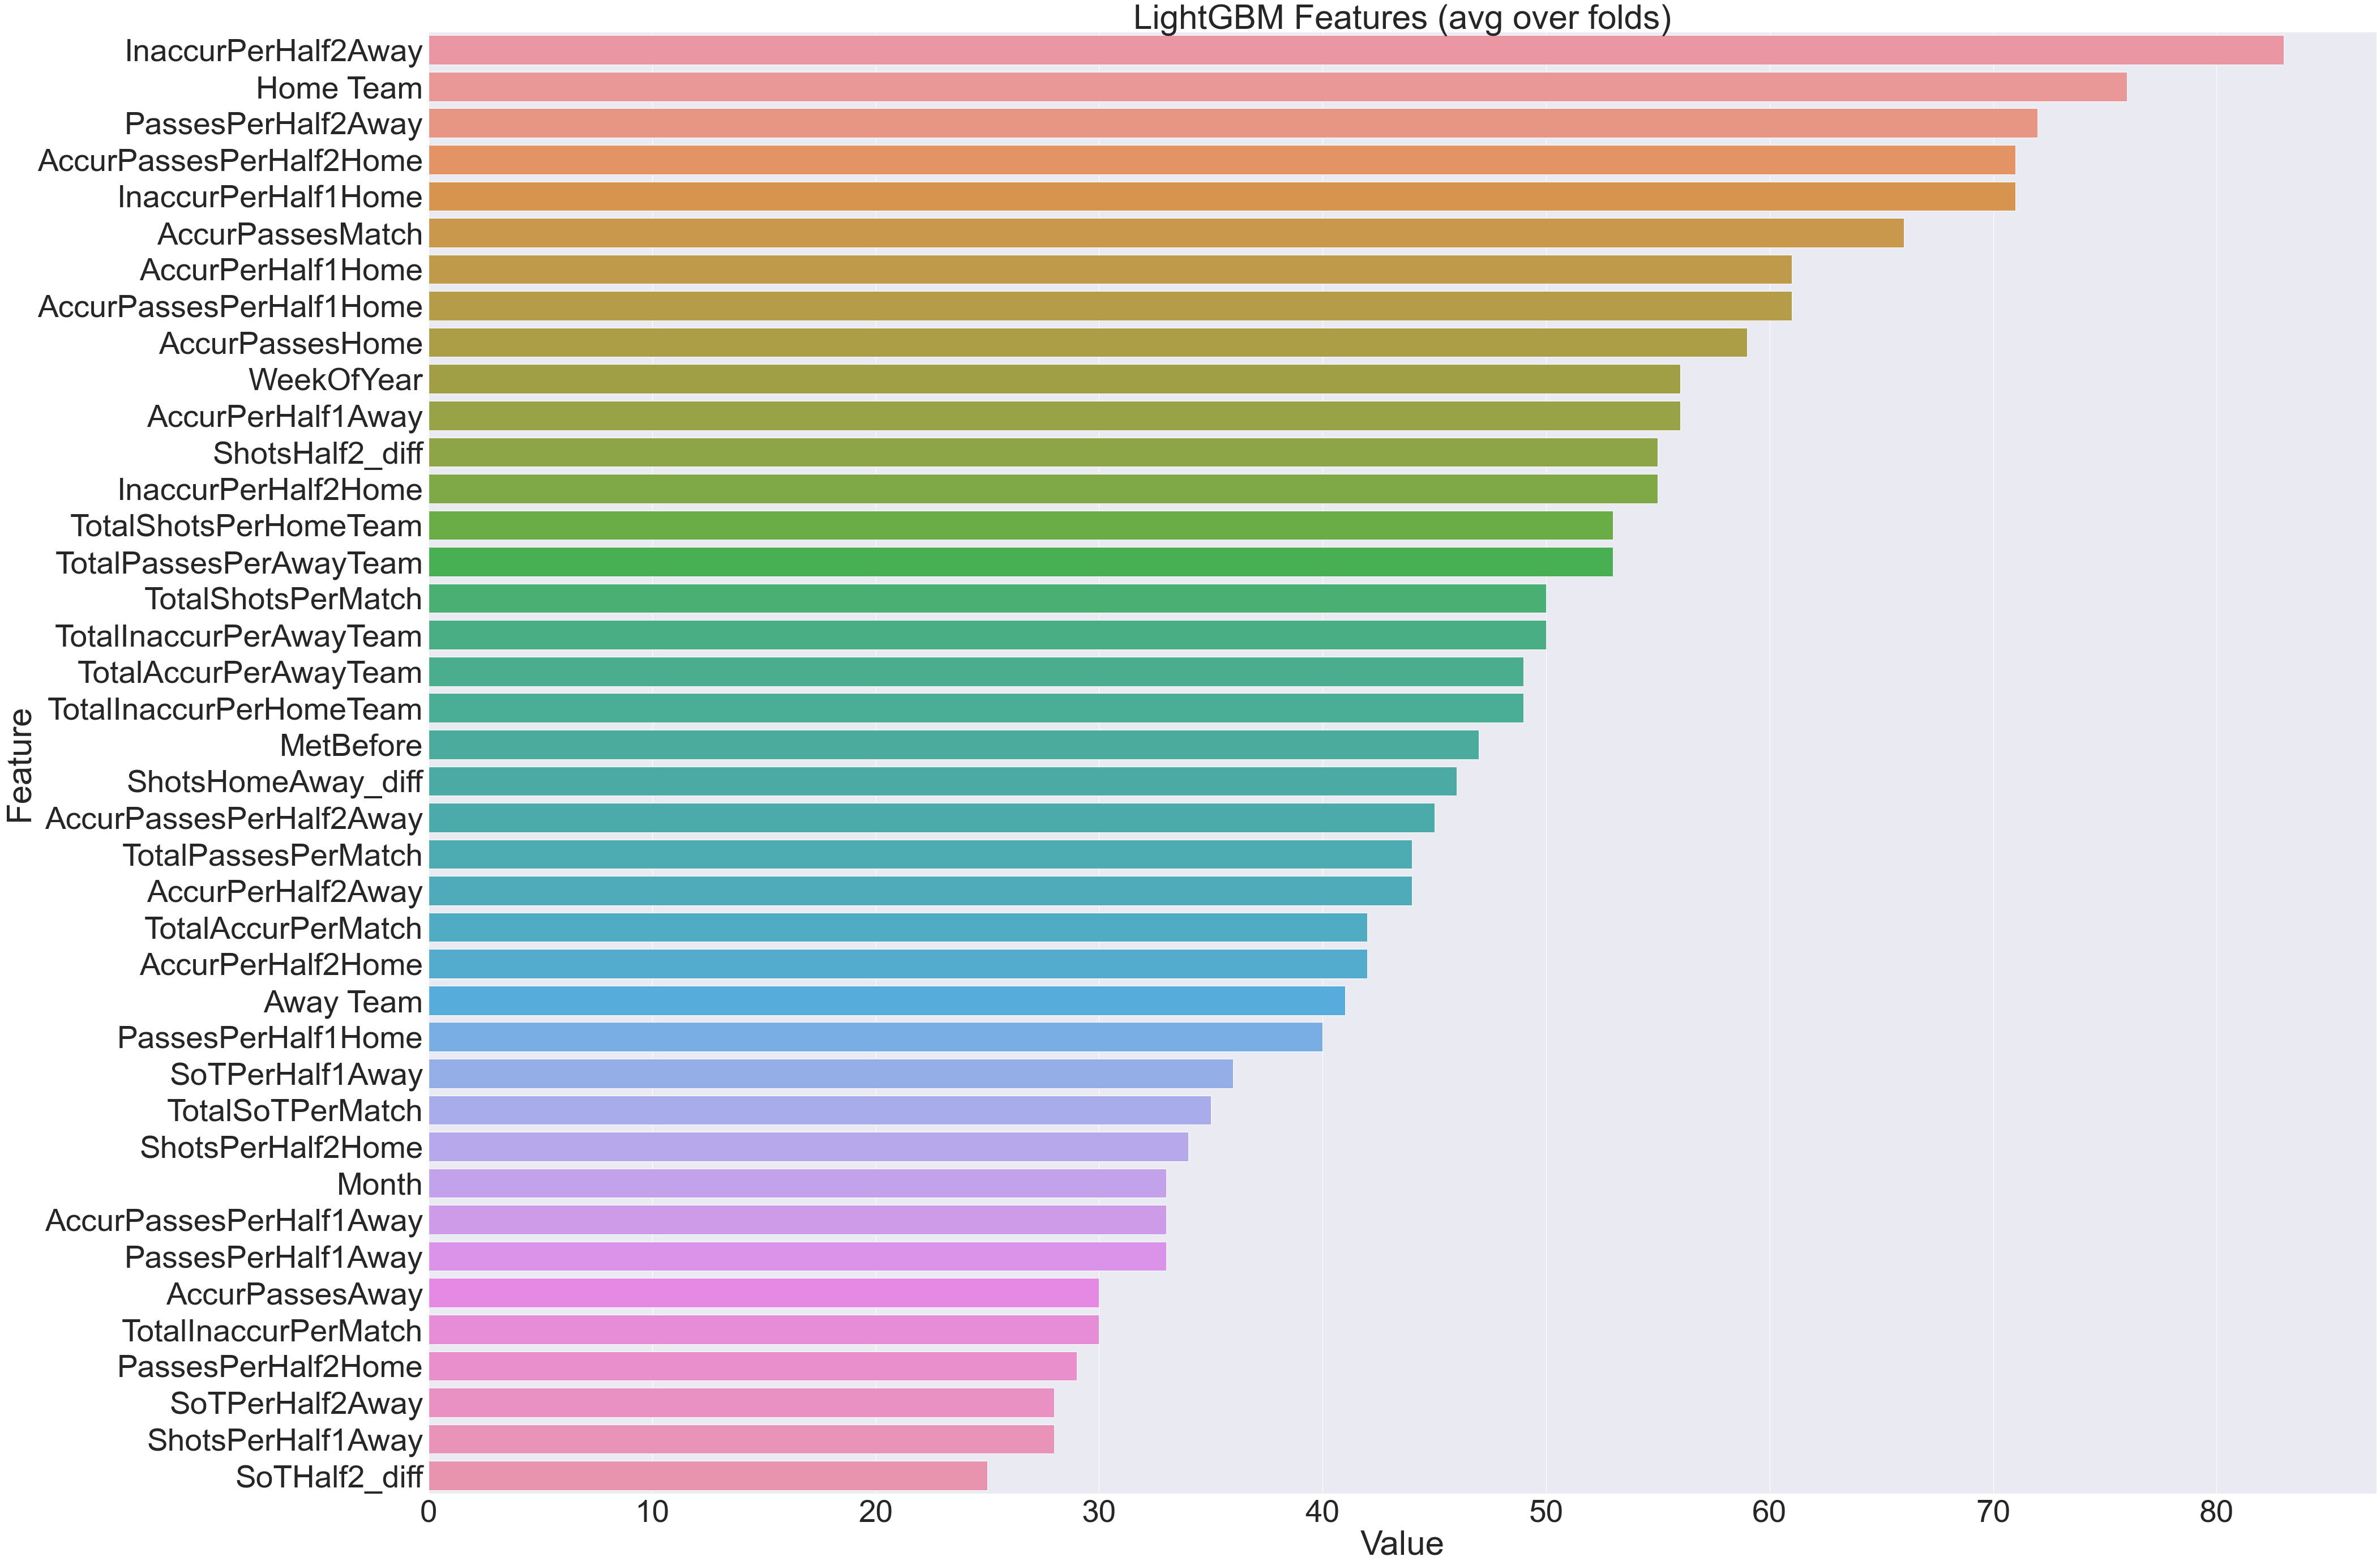

In [35]:
plotImp(lgbm,train_df.drop('Score',axis=1))

## Modeling

In [36]:
Predictions = pd.DataFrame()
X = train_df.drop('Score',axis=1)
y = train_df['Score']

lgbm.fit(X, y)
pred = lgbm.predict_proba(test_df)    
Predictions['Target_Away'] = pred[:,0]
Predictions['Target_Draw'] = pred[:,1]
Predictions['Target_Home'] = pred[:,2]

Predictions[['Target_Draw']] = Predictions[['Target_Draw']] - 0.04
Predictions[['Target_Away','Target_Home']] = Predictions[['Target_Away','Target_Home']] + 0.02

FinalPred = pd.Series(np.argmax(Predictions[['Target_Away','Target_Draw','Target_Home']].values, axis=1),
                         index=test_df.index)

In [37]:
submission = pd.DataFrame({"Game_ID": ID ,"Score": FinalPred.values})

submission['Score'] = submission.Score.map({
    0: 'Away win',
    1: 'Draw',
    2: 'Home Win',
})

submission.to_csv('FootballPrediction.csv',index=False)

## Leaderboard Score: 0.4785714285714286